In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d iabhishekofficial/mobile-price-classification

  0% 0.00/70.6k [00:00<?, ?B/s]
100% 70.6k/70.6k [00:00<00:00, 31.4MB/s]


In [4]:
!unzip mobile-price-classification.zip

Archive:  mobile-price-classification.zip
  inflating: test.csv                
  inflating: train.csv               


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [62]:
pd.set_option('display.max_columns', None)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [63]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [64]:
## mixing price range groups to simplify task
## mixing price range 0 and 1 into group 0 
## mixing price range 2 and 3 into group 1

train['price_range'] = train['price_range'].map({0:0, 1:0, 2:1, 3:1}).tolist()

In [56]:
test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [17]:
train['price_range'].unique()

array([0, 1])

In [18]:
def train_model(x, y, model):
  x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)
  clf = model()
  clf.fit(x_train, y_train)
  pred= clf.predict(x_test)
  return roc_auc_score(y_test, pred)

train_model(train.drop(['price_range'], axis=1), train['price_range'], LogisticRegression)

0.8775000000000001

In [22]:
## no feature engineering

x = train.drop(['price_range'], axis=1)
y = train['price_range']
x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)
clf = LogisticRegression()
clf.fit(x_train, y_train)
pred= clf.predict(x_test)
print(f"f1_score: {f1_score(y_test, pred)}")
print(f"precision: {precision_score(y_test, pred)}")
print(f"recall: {recall_score(y_test, pred)}")

f1_score: 0.8759493670886076
precision: 0.8871794871794871
recall: 0.865


##1

In [ ]:
def forward_selection(data, target, model):
    initial_features = data.columns.tolist()
    best_features = []
    max_score = 0
    best_feat = ''
    for i in initial_features:
      feature_score = train_model(data[i].values.reshape(-1, 1), target.values.reshape(-1, 1), model)
      if feature_score > max_score:
        best_feat = i
        max_score = feature_score
    
    best_features.append(best_feat)
    initial_features.remove(best_feat)

    for i in initial_features:
      temp = list()
      temp.extend(best_features)
      temp.append(i)
      feature_score = train_model(data[temp], target, LogisticRegression)
      if feature_score >= max_score:
        max_score = feature_score
        best_features.append(i)

    return best_features

forward_selection(train.drop(['price_range'], axis=1), train['price_range'], LogisticRegression)

['ram',
 'battery_power',
 'four_g',
 'm_dep',
 'mobile_wt',
 'pc',
 'px_width',
 'wifi']

##2

In [ ]:
best_features = forward_selection(train.drop(['price_range'], axis=1), train['price_range'], LogisticRegression)

x = train.drop(['price_range'], axis=1)[best_features]
y = train['price_range']
x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)
clf = LogisticRegression()
clf.fit(x_train, y_train)
pred= clf.predict(x_test)
print(f"f1_score: {f1_score(y_test, pred)}")
print(f"precision: {precision_score(y_test, pred)}")
print(f"recall: {recall_score(y_test, pred)}")

f1_score: 0.9319899244332494
precision: 0.9390862944162437
recall: 0.925


##3, 4

In [ ]:
pca = PCA(n_components=len(best_features))
x = train.drop(['price_range'], axis=1)[best_features]
y = train['price_range']
x_pca = pca.fit_transform(x)
x_pca.shape

(2000, 8)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_pca , y,test_size=.2, random_state=42, stratify=y)
clf = LogisticRegression()
clf.fit(x_train, y_train)
pred= clf.predict(x_test)
print(f"f1_score: {f1_score(y_test, pred)}")
print(f"precision: {precision_score(y_test, pred)}")
print(f"recall: {recall_score(y_test, pred)}")

f1_score: 0.9670886075949366
precision: 0.9794871794871794
recall: 0.955


##6

In [ ]:
x = train.drop(['price_range'], axis=1)
y = train['price_range']
x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)
clf = SVC()
clf.fit(x_train, y_train)
pred= clf.predict(x_test)
print(f"f1_score: {f1_score(y_test, pred)}")
print(f"precision: {precision_score(y_test, pred)}")
print(f"recall: {recall_score(y_test, pred)}")

f1_score: 0.9796954314720813
precision: 0.9948453608247423
recall: 0.965


##7

In [30]:
x = train.drop(['price_range'], axis=1)
y = train['price_range']
x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
cs = [1, 10 , 100]
for kernel in kernels:
  for c in cs:
    print(f"kernel: {kernel} c:{c}")
    clf = SVC(kernel=kernel, C=c)
    clf.fit(x_train, y_train)
    pred= clf.predict(x_test)
    print(f"f1_score: {f1_score(y_test, pred)}  precision: {precision_score(y_test, pred)}  recall: {recall_score(y_test, pred)}")

kernel: linear c:1
f1_score: 0.9874055415617129  precision: 0.9949238578680203  recall: 0.98
kernel: linear c:10
f1_score: 0.9849246231155778  precision: 0.98989898989899  recall: 0.98
kernel: linear c:100
f1_score: 0.9849246231155778  precision: 0.98989898989899  recall: 0.98
kernel: poly c:1
f1_score: 0.984848484848485  precision: 0.9948979591836735  recall: 0.975
kernel: poly c:10
f1_score: 0.9874686716791979  precision: 0.9899497487437185  recall: 0.985
kernel: poly c:100
f1_score: 0.9874686716791979  precision: 0.9899497487437185  recall: 0.985
kernel: rbf c:1
f1_score: 0.9796954314720813  precision: 0.9948453608247423  recall: 0.965
kernel: rbf c:10
f1_score: 0.9874686716791979  precision: 0.9899497487437185  recall: 0.985
kernel: rbf c:100
f1_score: 0.9874686716791979  precision: 0.9899497487437185  recall: 0.985
kernel: sigmoid c:1
f1_score: 0.43373493975903615  precision: 0.4186046511627907  recall: 0.45
kernel: sigmoid c:10
f1_score: 0.4213075060532688  precision: 0.408450704

##8

In [35]:
## soft margin

x = train.drop(['price_range'], axis=1)
y = train['price_range']
x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)
clf = SVC(kernel='linear', C=1)
clf.fit(x_train, y_train)
pred= clf.predict(x_test)
print(f"f1_score: {f1_score(y_test, pred)}")
print(f"precision: {precision_score(y_test, pred)}")
print(f"recall: {recall_score(y_test, pred)}")

f1_score: 0.9874055415617129
precision: 0.9949238578680203
recall: 0.98


In [36]:
## hard margin

x = train.drop(['price_range'], axis=1)
y = train['price_range']
x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)
clf = SVC(kernel= 'linear', C=1000)
clf.fit(x_train, y_train)
pred= clf.predict(x_test)
print(f"f1_score: {f1_score(y_test, pred)}")
print(f"precision: {precision_score(y_test, pred)}")
print(f"recall: {recall_score(y_test, pred)}")

f1_score: 0.9849246231155778
precision: 0.98989898989899
recall: 0.98


##9

###a

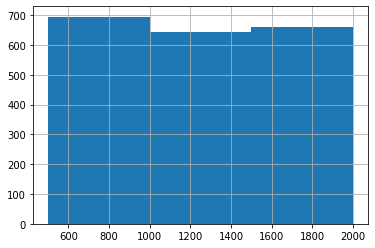

In [ ]:
train['battery_power'].hist(bins=3)

In [43]:
bins = [0, 1000, 1500, 2000]
labels = [1, 2, 3]
train['battery_power'] = pd.cut(train['battery_power'],bins = bins, labels = labels)
train.head()


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,0
1,2,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,1
2,1,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,1
3,1,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,1
4,3,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,0


In [66]:
def apply_binning_power_battery(df:pd.DataFrame):
  bins = [0, 1000, 1500, 2000]
  labels = [1, 2, 3]
  new_df = df.copy()
  new_df['battery_power'] = pd.cut(new_df['battery_power'],bins = bins, labels = labels)
  return new_df

apply_binning_power_battery(train)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,0
1,2,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,1
2,1,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,1
3,1,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,1
4,3,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0,0
1996,3,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1,1
1997,3,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0,1
1998,3,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1,0


###b

In [41]:
train = train.astype({'four_g':'category', 'three_g':'category', 'dual_sim':'category', 'blue':'category', 'touch_screen':'category', 'wifi':'category'})

In [ ]:
pd.get_dummies(train)

,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range,area,battery_power_bin-1,battery_power_bin-2,battery_power_bin-3,blue_0,blue_1,dual_sim_0,dual_sim_1,four_g_0,four_g_1,three_g_0,three_g_1,touch_screen_0,touch_screen_1,wifi_0,wifi_1
0,2.2,1,7,0.6,188,2,2,20,756,2549,9,7,19,0,15120.0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
1,0.5,0,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1799140.0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0
2,0.5,2,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,2167308.0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0
3,2.5,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,2171776.0,1,0,0,0,1,1,0,1,0,0,1,1,0,1,0
4,1.2,13,44,0.6,141,2,14,1208,1212,1411,8,2,15,0,1464096.0,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.5,0,2,0.8,106,6,14,1222,1890,668,13,4,19,0,2309580.0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0
1996,2.6,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1797975.0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1
1997,0.9,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1416576.0,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0
1998,0.9,4,46,0.1,145,5,5,336,670,869,18,10,19,0,225120.0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1


In [71]:
def apply_one_hot_encoding(df:pd.DataFrame, categorical_features:list):
  dtypes = {}
  for i in categorical_features:
    dtypes[i]='category'
  new_df = df.copy()
  new_df = new_df.astype(dtypes)
  new_df = pd.get_dummies(new_df)
  return new_df

apply_one_hot_encoding(train, ['four_g', 'three_g', 'dual_sim', 'blue', 'touch_screen', 'wifi'])

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range,blue_0,blue_1,dual_sim_0,dual_sim_1,four_g_0,four_g_1,three_g_0,three_g_1,touch_screen_0,touch_screen_1,wifi_0,wifi_1
0,842,2.2,1,7,0.6,188,2,2,20,756,2549,9,7,19,0,1,0,1,0,1,0,1,0,1,0,0,1
1,1021,0.5,0,53,0.7,136,3,6,905,1988,2631,17,3,7,1,0,1,0,1,0,1,0,1,0,1,1,0
2,563,0.5,2,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,0,1,0,1,0,1,0,1,0,1,1,0
3,615,2.5,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,1,1,0,1,0,0,1,1,0,1,0
4,1821,1.2,13,44,0.6,141,2,14,1208,1212,1411,8,2,15,0,0,1,1,0,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,0.5,0,2,0.8,106,6,14,1222,1890,668,13,4,19,0,0,1,0,1,0,1,0,1,0,1,1,0
1996,1965,2.6,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,0,1,0,1,1,0,0,1,0,1,0,1
1997,1911,0.9,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0,0,1,0,1,0,1,0,1,1,0
1998,1512,0.9,4,46,0.1,145,5,5,336,670,869,18,10,19,0,1,0,1,0,0,1,0,1,0,1,0,1


###c

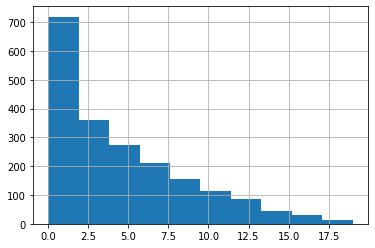

In [37]:
train['fc'].hist()

In [ ]:
train['fc_log'] = np.log(train['fc']+2)

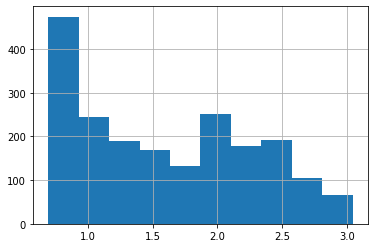

In [ ]:
train['fc_log'].hist()

In [73]:
def apply_log_transformation(df:pd.DataFrame):
  new_df = df.copy()
  new_df['fc'] = np.log(new_df['fc']+2)
  return new_df

apply_log_transformation(train)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1.098612,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,0
1,1021,1,0.5,1,0.693147,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,1
2,563,1,0.5,1,1.386294,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,1
3,615,1,2.5,0,0.693147,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,1
4,1821,1,1.2,0,2.708050,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0.693147,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0.693147,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1,1
1997,1911,0,0.9,1,1.098612,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0,1
1998,1512,0,0.9,0,1.791759,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1,0


###d

In [ ]:
train['area'] = train.apply(lambda x: x.px_height *	x.px_width, axis=1)

In [74]:
def add_area_feature(df:pd.DataFrame):
  new_df = df.copy()
  new_df['area'] = new_df.apply(lambda x: x.px_height *	x.px_width, axis=1)
  return new_df

add_area_feature(train)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,area
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,0,15120.0
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,1,1799140.0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,1,2167308.0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,1,2171776.0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,0,1464096.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0,0,2309580.0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1,1,1797975.0
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0,1,1416576.0
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1,0,225120.0


##10

In [75]:
def train_svm(df:pd.DataFrame):
  x = df.drop(['price_range'], axis=1)
  y = df['price_range']
  x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)

  clf = SVC()
  clf.fit(x_train, y_train)
  pred= clf.predict(x_test)
  print(f"f1_score: {f1_score(y_test, pred)}")
  print(f"precision: {precision_score(y_test, pred)}")
  print(f"recall: {recall_score(y_test, pred)}")

In [76]:
## after applying binning to battery_power

new_df = apply_binning_power_battery(train)
train_svm(new_df)

f1_score: 0.9329896907216496
precision: 0.9627659574468085
recall: 0.905


In [77]:
## after applying one_hot_encoding

new_df = apply_one_hot_encoding(train, ['four_g', 'three_g', 'dual_sim', 'blue', 'touch_screen', 'wifi'])
train_svm(new_df)

f1_score: 0.9796954314720813
precision: 0.9948453608247423
recall: 0.965


In [78]:
## after applying log transformain on fc

new_df = apply_log_transformation(train)
train_svm(new_df)

f1_score: 0.9796954314720813
precision: 0.9948453608247423
recall: 0.965


In [79]:
## after adding area feature

new_df = add_area_feature(train)
train_svm(new_df)

f1_score: 0.45029239766081874
precision: 0.5422535211267606
recall: 0.385


In [80]:
## after applying all feature engineering methods

new_df = apply_binning_power_battery(train)
new_df = apply_one_hot_encoding(new_df, ['battery_power', 'four_g', 'three_g', 'dual_sim', 'blue', 'touch_screen', 'wifi'])
new_df = apply_log_transformation(new_df)
new_df = add_area_feature(new_df)
train_svm(new_df)

f1_score: 0.45029239766081874
precision: 0.5422535211267606
recall: 0.385


In [81]:
## after applying all feature engineering methods and removing area feature

new_df = apply_binning_power_battery(train)
new_df = apply_one_hot_encoding(new_df, ['battery_power', 'four_g', 'three_g', 'dual_sim', 'blue', 'touch_screen', 'wifi'])
new_df = apply_log_transformation(new_df)
#new_df = add_area_feature(new_df)
train_svm(new_df)

f1_score: 0.9329896907216496
precision: 0.9627659574468085
recall: 0.905


##12

In [57]:
x = train.drop(['price_range'], axis=1)
y = train['price_range']
x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
pred= clf.predict(x_test)
print(f"f1_score: {f1_score(y_test, pred)}")
print(f"precision: {precision_score(y_test, pred)}")
print(f"recall: {recall_score(y_test, pred)}")

f1_score: 0.9393939393939393
precision: 0.9489795918367347
recall: 0.93


##13

In [ ]:
x = train.drop(['price_range'], axis=1)
y = train['price_range']
x_train,x_test,y_train,y_test=train_test_split(x , y,test_size=.2, random_state=42, stratify=y)


depth = [10, 50, 100 ,150]
split = [2, 8, 15, 20]
for d in depth:
  for s in split:
    clf = DecisionTreeClassifier(max_depth=d, min_samples_split=s)
    clf.fit(x_train, y_train)
    pred= clf.predict(x_test)
    print(f"max depth: {d}")
    print(f"min_sample_split: {s}")
    print(f"f1_score: {f1_score(y_test, pred)}")
    print()

max depth: 10
min_sample_split: 2
f1_score: 0.949748743718593

max depth: 10
min_sample_split: 8
f1_score: 0.9516539440203563

max depth: 10
min_sample_split: 15
f1_score: 0.9363867684478372

max depth: 10
min_sample_split: 20
f1_score: 0.9312977099236642

max depth: 50
min_sample_split: 2
f1_score: 0.9545454545454546

max depth: 50
min_sample_split: 8
f1_score: 0.9516539440203563

max depth: 50
min_sample_split: 15
f1_score: 0.9363867684478372

max depth: 50
min_sample_split: 20
f1_score: 0.9312977099236642

max depth: 100
min_sample_split: 2
f1_score: 0.9393939393939393

max depth: 100
min_sample_split: 8
f1_score: 0.9516539440203563

max depth: 100
min_sample_split: 15
f1_score: 0.9363867684478372

max depth: 100
min_sample_split: 20
f1_score: 0.9312977099236642

max depth: 150
min_sample_split: 2
f1_score: 0.9414758269720102

max depth: 150
min_sample_split: 8
f1_score: 0.9465648854961832

max depth: 150
min_sample_split: 15
f1_score: 0.9363867684478372

max depth: 150
min_sample_s